# FO

In [1]:
import os

password = "jetbot"
command = "sudo -S systemctl restart nvargus-daemon" #can be any command but don't forget -S as it enables input from stdin
os.system('echo %s | %s' % (password, command))

0

In [2]:
# ToDo: Remove pathlib, only here to find correct paths.
# import pathlib
# print(pathlib.Path().absolute())

# As we are writing in a seperate folder we need to add paths to the other modules not contained in the current system paths.
import sys
sys.path.insert(1,'/home/jetbot')
sys.path.insert(1,'/home/jetbot/monodepth2')

In [3]:
from jetson import utils, inference
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image as pil
import cv2
import matplotlib.pyplot as plt

from jetbot import Camera, bgr8_to_jpeg, Robot

import time
import numpy as np

jetson.utils.__init__.py
jetson.inference.__init__.py


# Setup

In [4]:
camwidth, camheight = 320, 240
cam = Camera.instance(width=camwidth, height=camheight)

try:
    print("Camspecs are to specifications: ", ((cam.width == camwidth) and (cam.height == camheight)))
    print(cam.width, cam.height)
except NameError:
    pass


net = inference.detectNet("ssd-mobilenet-v2", threshold=0.4)

with open('coco_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]

rob = Robot()
rob.stop()

# camera = utils.gstCamera()

Camspecs are to specifications:  True
320 240


## Run Once

In [43]:
try:
    arr = cam.value
    frame = cv2.cvtColor(arr, cv2.COLOR_BGR2RGBA)
    img = utils.cudaFromNumpy(frame)
    detections = net.Detect(image = img, width = camwidth, height = camheight, overlay = "none")
    print(len(detections))
    for d in detections:
        if d.ClassID not in []: #[62, 65]:
            print(d, classes[d.ClassID])
except KeyboardInterrupt:
    pass

3
<detectNet.Detection object>
   -- ClassID: 1
   -- Confidence: 0.661376
   -- Left:    1.90341
   -- Top:     0
   -- Right:   317.832
   -- Bottom:  159.111
   -- Width:   315.929
   -- Height:  159.111
   -- Area:    50267.7
   -- Center:  (159.868, 79.5555) person
<detectNet.Detection object>
   -- ClassID: 65
   -- Confidence: 0.533762
   -- Left:    0
   -- Top:     131.494
   -- Right:   319
   -- Bottom:  238.817
   -- Width:   319
   -- Height:  107.323
   -- Area:    34236
   -- Center:  (159.5, 185.156) bed
<detectNet.Detection object>
   -- ClassID: 1
   -- Confidence: 0.630685
   -- Left:    167.311
   -- Top:     3.89794
   -- Right:   319
   -- Bottom:  142.042
   -- Width:   151.689
   -- Height:  138.144
   -- Area:    20954.9
   -- Center:  (243.156, 72.9698) person


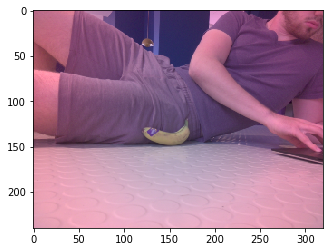

In [45]:
plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGBA))

yee

In [17]:
try:
    img, width, height = camera.CaptureRGBA()
    detections = net.Detect(img, width, height)
    print(detections)
    print(dir(detections[0]))
    # bgr8_to_jpeg(camera.value)
    for d in detections:
        print(d, classes[d.ClassID])
except KeyboardInterrupt:
    pass

NameError: name 'camera' is not defined

In [ ]:
# CAM TEARDOWN

dir(camera)

#cam.unobserve_all()
# cam.stop()
camera.Close()


In [ ]:
camera.Close()

Videre mens vent på AIDS

In [ ]:
def update(change):
    global robot, cam #era
    try:
        arr = change['new'] 
        frame = cv2.cvtColor(arr, cv2.COLOR_BGR2RGBA)
        camCuda = utils.cudaFromNumpy(frame)
        detections = net.Detect(image = camCuda, width = camwidth, height = camheight, overlay = "none")
        det = False
        for d in detections:
            if d.ClassID == 47:
                # print(d.Height/camheight)
                center_x, center_y = d.Center
                det = True
                break
        if det:
            if d.Height/camheight > 0.4:
                rob.stop()
            else:
                x = center_x/camwidth - 0.5 # ToDo: Camwidth is pobably not concurrent with detection coordinate output
                rob.set_motors(
                    float(0.4 + 0.8 * x), # left
                    float(0.4 - 0.8 * x) # Right
                ) 
                print(rob.left_motor.value, rob.right_motor.value)
            
            
                
                
            
    except KeyboardInterrupt:
        cam.unobserve(update, names='value')
        cam.stop()
        print('Loop successfully ended.')

# Ass

In [ ]:
update({'new': cam.value})
cam.observe(update, names='value')

## Setup

In [ ]:
camCuda = utils.cudaFromNumpy(cam.value)
detections = net.Detect(camCuda, camwidth, camheight)

print(detections)

for d in detections:
    print(classes[d.ClassID])

In [ ]:
mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean, stdev)

def preprocess(camera_value): # Preprocessing for camera format --> Network input format
    x= cv2.cvtColor(camera_value, cv2.COLOR_BGR2RGB) #(x, i)
    return x

In [ ]:
u = cam.value
x = utils.cudaFromNumpy(u)
y = utils.cudaToNumpy(x, camwidth, camheight, 3).astype(np.uint8)

In [ ]:
plt.imshow(y)

In [ ]:
print(y[200][200])
print(u[200][200])

In [ ]:
plt.imshow(u)

In [ ]:
detections = net.Detect(camCuda, 224, 224)

In [ ]:
print(detections)
for d in detections:
    print(classes[d.ClassID])

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
if __name__ == '__main__':
    print(device)

model = models.resnet50(pretrained=True)
model = model.to(device)

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean, stdev)

def preprocess(camera_value): # Preprocessing for camera format --> Network input format
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #(x, i)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

'''transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])'''

model.eval()

with open('classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
    
camwidth, camheight = 224, 224
cam = Camera.instance(width=camwidth, height=camheight)

rob = Robot()

In [ ]:
with open('classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
classes[968]

## YEET

In [ ]:
def update(change):
    # global robot, prob_blocked
    try:
        x = change['new'] 
        x = preprocess(x)
        out = model(x)

        # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
        _, index = torch.max(out, 1)
        if index in [967, 968, 504, 505]:
            rob.forward(0.4)
            time.sleep(0.5)
            rob.stop()
        pct = F.softmax(out, dim=1)[0] * 100
        print(classes[index[0]], round(pct[index[0]].item(), 3))
        time.sleep(0.1)
    except KeyboardInterrupt:
        cam.stop()
        print('Loop successfully ended.')

In [ ]:
update({'new': cam.value})
cam.observe(update, names='value')

## Return Max

In [ ]:
k, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

### Top 5

In [ ]:
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print([(classes[idx], percentage[idx].item()) for idx in indices[0][:5]])

# Pseudokode:

Timeline:
- Ta inn en gjenstand
- Kjør rundt
- Se etter samme gjenstand
- Identifiser som samme gjenstand
- Kjør bort til den


Kode:

Ta inn gjenstand, gjør estimering, lagre ID

som del av update<cam.value> spesial funskjonen: konstant identifiser gjenstander.

Hvis den gjetter samme id som er lagret, ovveride(break) og gå til oppsøkingsfunksjon.



In [ ]:
while True:
    try:
        img = pil.fromarray(cam.value.astype('uint8'),'RGB') #.rotate(180)
        # img = Image.open("a.jpg")
        img_t = transform(img)
        batch_t = torch.unsqueeze(img_t, 0).cuda()
        out = model(batch_t)
        
        _, index = torch.max(out, 1)
        percentage = F.softmax(out, dim=1)[0] * 100
        print(classes[index[0]], percentage[index[0]].item())
        time.sleep(0.1)
    except KeyboardInterrupt:
        cam.stop()
        print('Loop successfully ended.')
        break

## Auto-forsøk

In [ ]:
mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean, stdev)

def preprocess(camera_value): # Preprocessing for camera format --> Network input format
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #(x, i)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = transform(x)
    x = x.to(device)
    x = x[None, ...]
    return x

transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])


In [ ]:
def prep(cam_val):
    global device, normalize
    x = pil.fromarray(cam_val.astype('uint8'),'RGB')
    x.show()
    x = transform(x)
    x = torch.unsqueeze(img_t, 0)
    x = x.to(device)
    x = x[None, ...]
    return x



def update(change):
    # global robot, prob_blocked
    x = change['new'] 
    print(x.shape)
    x = prep(x)
    print(x.shape)
    out = model(x)
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    _, index = torch.max(out, 1)
    pct = F.softmax(out, dim=1)[0] * 100
    print(classes[index[0]], round(pct[index[0]].item(), 3))
    time.sleep(0.01)

In [ ]:
def update(change):
    # global robot, prob_blocked
    x = change['new'] 
    x = preprocess(x)
    out = model(x)
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    _, index = torch.max(out, 1)
    pct = F.softmax(out, dim=1)[0] * 100
    print(classes[index[0]], round(pct[index[0]].item(), 3))
        
    time.sleep(0.01)

# update({'new': cam.value})
# cam.observe(update, names='value')

In [ ]:
cam.unobserve(update, names='value')


In [ ]:
dir(cam)

In [ ]:
cam.unobserve_all()